# Нейросетевые модели:
# Зависимость цены от переменных "общая площадь", "жилая площадь", "площадь кухни"

In [0]:
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import torch
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/content/nedvig_1room_data.csv', delimiter=';')
df.head()

,Square,Square_living,Square_kitchen,Price
0,40.0,20.0,10.0,1596.0
1,37.0,17.0,8.0,1344.0
2,38.0,18.0,9.0,1148.0
3,27.0,14.0,6.0,686.0
4,30.0,17.0,6.0,1008.0


In [3]:
df.describe()

,Square,Square_living,Square_kitchen,Price
count,355.000000,355.000000,355.000000,355.000000
mean,54.280282,31.460563,9.486197,1630.456051
std,17.114759,13.025500,2.878413,493.875473
min,23.000000,8.000000,5.000000,594.000000
25%,40.000000,20.000000,7.000000,1298.000000
50%,52.000000,30.000000,9.000000,1512.000000
75%,68.000000,42.000000,11.000000,1944.000000
max,103.000000,72.000000,19.000000,3250.800000


In [0]:
Y = df['Price']
X = df[['Square', 'Square_kitchen', 'Square_living']]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=50)

In [33]:
x_train, y_train, x_test, y_test = map(
    torch.tensor, (X_train.values.astype('float32'), Y_train.values.astype('float32'), 
                   X_test.values.astype('float32'), Y_test.values.astype('float32'))
)
y_train, y_test = y_train.unsqueeze(1), y_test.unsqueeze(1)
print(x_train.size(), y_train.size(), x_test.size(), y_test.size())

torch.Size([248, 3]) torch.Size([248, 1]) torch.Size([107, 3]) torch.Size([107, 1])


In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
x_train, y_train, x_test, y_test = x_train.to(device), y_train.to(device), x_test.to(device), y_test.to(device)

cuda:0


# Модель 1:

*Функция потерь* - MAE, *aлгоритм оптимизации* - Adam

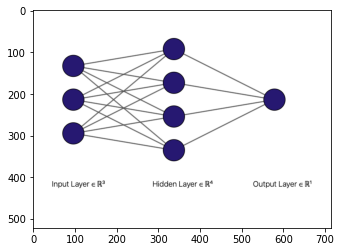

In [7]:
image = img.imread('/content/model1.png')
plt.imshow(image)
plt.show()

In [0]:
class LinNet(torch.nn.Module):
  def __init__(
      self,
      *,
      input_size, 
      n_hidden_neurons, 
      output_size,
      ):
    super().__init__()

    self.linear_input = torch.nn.Linear(
        input_size, 
        n_hidden_neurons,
        bias=True,
        )
    self.linear_output = torch.nn.Linear(
        n_hidden_neurons, 
        output_size,
        )

  def forward(self, x):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    x = x.to(device)
    x = self.linear_input(x)
    x = self.linear_output(x)
    return x

  def train_one_epoch(self, *, x, y, optimizer_func, loss_func):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    x = x.to(device)
    y = y.to(device)

    optimizer_func.zero_grad()
    y_pred = self.forward(x)
    loss_value=loss_func(y_pred, y)
    loss_value.backward()
    optimizer_func.step()

    return loss_value.data


**Обучение**

In [0]:
input_size = x_train.size()[1]
output_size = 1
n_hidden_neurons = 4
net = LinNet(
    input_size=input_size, 
    n_hidden_neurons=n_hidden_neurons, 
    output_size=output_size,
    )
net.to(device)
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters())

In [17]:
epoch_indexes, loss_values = [], []
for epoch_index in range(30000): 
  epoch_loss_value = net.train_one_epoch(x=x_train, y=y_train, optimizer_func=optimizer, loss_func=loss_fn)
  if epoch_index%1000 == 0:
      epoch_indexes.append(epoch_index)
      loss_values.append(epoch_loss_value.data)
      print(f'Эпоха {epoch_index}, ошибка {epoch_loss_value.data}')

Эпоха 0, ошибка 1652.6103515625
Эпоха 1000, ошибка 788.281494140625
Эпоха 2000, ошибка 235.8050537109375
Эпоха 3000, ошибка 232.54144287109375
Эпоха 4000, ошибка 228.5703125
Эпоха 5000, ошибка 225.92747497558594
Эпоха 6000, ошибка 224.6457061767578
Эпоха 7000, ошибка 223.68638610839844
Эпоха 8000, ошибка 222.90969848632812
Эпоха 9000, ошибка 221.9724578857422
Эпоха 10000, ошибка 220.8077850341797
Эпоха 11000, ошибка 219.44876098632812
Эпоха 12000, ошибка 217.98194885253906
Эпоха 13000, ошибка 216.258056640625
Эпоха 14000, ошибка 214.23629760742188
Эпоха 15000, ошибка 212.00296020507812
Эпоха 16000, ошибка 209.8365936279297
Эпоха 17000, ошибка 207.3707733154297
Эпоха 18000, ошибка 204.85256958007812
Эпоха 19000, ошибка 202.89453125
Эпоха 20000, ошибка 202.19874572753906
Эпоха 21000, ошибка 201.81224060058594
Эпоха 22000, ошибка 201.57705688476562
Эпоха 23000, ошибка 201.44894409179688
Эпоха 24000, ошибка 201.44723510742188
Эпоха 25000, ошибка 201.4471893310547
Эпоха 26000, ошибка 201.44

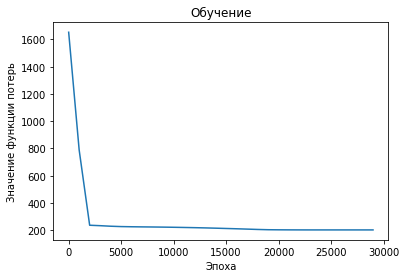

In [18]:
plt.plot(epoch_indexes, loss_values)
plt.title('Обучение')
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.show()

**Предсказание**

In [35]:
with torch.no_grad():
  y_pred = net(x_test)
  loss_value=loss_fn(y_pred, y_test)
  

y_pred_1 = y_pred.cpu().numpy()
y_test_1 = y_test.cpu().numpy()

print(f'MAE на предсказанных данных - {loss_value.data}')

MAE на предсказанных данных - 203.7039794921875


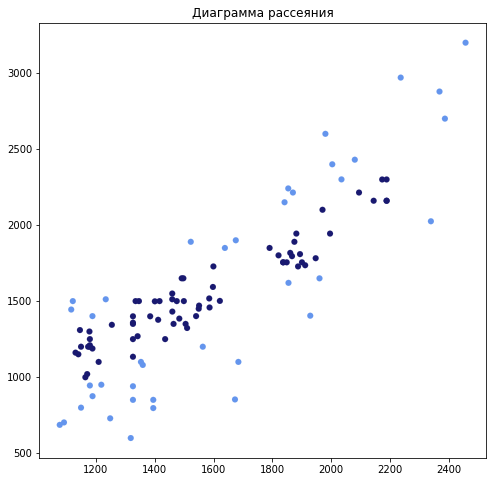

In [36]:
col = np.empty_like(y_pred_1)
right_points = (abs(y_pred_1 - y_test_1) < 200)    
points = (abs(y_pred_1 - y_test_1) > 200)

col[right_points] = 1
col[points] = 0
colors = ['midnightblue' if i == 1.0 else 'cornflowerblue' for i in col]


plt.figure(figsize=(8,8))
scatter = plt.scatter(y_pred_1, y_test_1, c=colors, linewidth=0.1)
plt.title('Диаграмма рассеяния')
plt.show()

# Модель 2:
*Функция потерь* - MAE, *aлгоритм оптимизации* - RMSProp

(обучение достигло результата Модели 1 за два раза меньшее количество эпох)

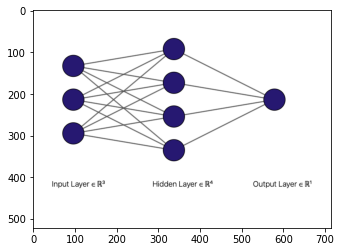

In [48]:
image = img.imread('/content/model1.png')
plt.imshow(image)
plt.show()

In [0]:
input_size = x_train.size()[1]
output_size = 1
n_hidden_neurons = 4
net = LinNet(
    input_size=input_size, 
    n_hidden_neurons=n_hidden_neurons, 
    output_size=output_size,
    )
net.to(device)
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.RMSprop(net.parameters())

In [44]:
epoch_indexes, loss_values = [], []
for epoch_index in range(15000): 
  epoch_loss_value = net.train_one_epoch(x=x_train, y=y_train, optimizer_func=optimizer, loss_func=loss_fn)
  if epoch_index%1000 == 0:
      epoch_indexes.append(epoch_index)
      loss_values.append(epoch_loss_value.data)
      print(f'Эпоха {epoch_index}, ошибка {epoch_loss_value.data}')

Эпоха 0, ошибка 1649.1275634765625
Эпоха 1000, ошибка 219.51959228515625
Эпоха 2000, ошибка 207.7303009033203
Эпоха 3000, ошибка 202.11602783203125
Эпоха 4000, ошибка 201.89259338378906
Эпоха 5000, ошибка 202.12554931640625
Эпоха 6000, ошибка 201.97410583496094
Эпоха 7000, ошибка 201.7987060546875
Эпоха 8000, ошибка 202.1490020751953
Эпоха 9000, ошибка 201.7917938232422
Эпоха 10000, ошибка 201.7335205078125
Эпоха 11000, ошибка 202.14736938476562
Эпоха 12000, ошибка 201.9698028564453
Эпоха 13000, ошибка 201.57528686523438
Эпоха 14000, ошибка 201.5028533935547


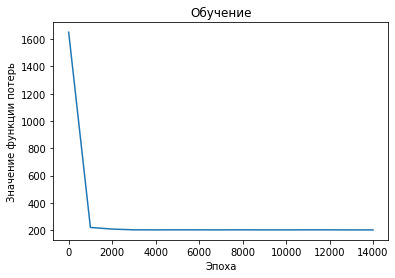

In [45]:
plt.plot(epoch_indexes, loss_values)
plt.title('Обучение')
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.show()

In [46]:
with torch.no_grad():
  y_pred = net(x_test)
  loss_value=loss_fn(y_pred, y_test)
  

y_pred_2 = y_pred.cpu().numpy()
y_test_2 = y_test.cpu().numpy()

print(f'MAE на предсказанных данных - {loss_value.data}')

MAE на предсказанных данных - 203.29737854003906


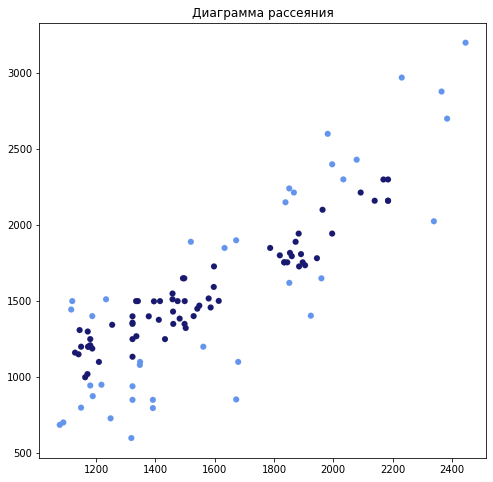

In [47]:
col = np.empty_like(y_pred_2)
right_points = (abs(y_pred_2 - y_test_2) < 200)    
points = (abs(y_pred_2 - y_test_2) > 200)

col[right_points] = 1
col[points] = 0
colors = ['midnightblue' if i == 1.0 else 'cornflowerblue' for i in col]


plt.figure(figsize=(8,8))
scatter = plt.scatter(y_pred_2, y_test_2, c=colors, linewidth=0.1)
plt.title('Диаграмма рассеяния')
plt.show()

# Модель 3:
*Функция потерь* - MAE, *aлгоритм оптимизации* - RMSProp

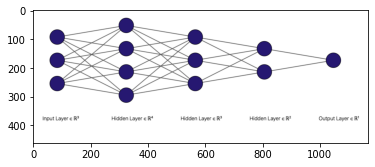

In [56]:
image = img.imread('/content/model3.png')
plt.imshow(image)
plt.show()

In [0]:
class LinNet_(torch.nn.Module):
  def __init__(
      self,
      *,
      input_size, 
      n_hidden_neurons1, 
      n_hidden_neurons2,
      n_hidden_neurons3,
      output_size,
      ):
    super().__init__()

    self.linear_input1 = torch.nn.Linear(
        input_size, 
        n_hidden_neurons1,
        bias=True,
        )
    self.linear_input2 = torch.nn.Linear(
        n_hidden_neurons1, 
        n_hidden_neurons2,
        bias=True,
        )
    self.linear_input3 = torch.nn.Linear(
        n_hidden_neurons2, 
        n_hidden_neurons3,
        bias=True,
        )
    self.linear_output = torch.nn.Linear(
        n_hidden_neurons3, 
        output_size,
        )

  def forward(self, x):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    x = x.to(device)
    x = self.linear_input1(x)
    x = self.linear_input2(x)
    x = self.linear_input3(x)
    x = self.linear_output(x)
    return x

  def train_one_epoch(self, *, x, y, optimizer_func, loss_func):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    x = x.to(device)
    y = y.to(device)

    optimizer_func.zero_grad()
    y_pred = self.forward(x)
    loss_value=loss_func(y_pred, y)
    loss_value.backward()
    optimizer_func.step()

    return loss_value.data


In [0]:
input_size = x_train.size()[1]
output_size = 1
n_hidden_neurons1 = 4
n_hidden_neurons2 = 3
n_hidden_neurons3 = 2
net_ = LinNet_(
    input_size=input_size, 
    n_hidden_neurons1=n_hidden_neurons1, 
    n_hidden_neurons2=n_hidden_neurons2,
    n_hidden_neurons3=n_hidden_neurons3,
    output_size=output_size,
    )
net_.to(device)
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.RMSprop(net_.parameters())

In [71]:
net_.parameters

<bound method Module.parameters of LinNet_(
  (linear_input1): Linear(in_features=3, out_features=4, bias=True)
  (linear_input2): Linear(in_features=4, out_features=3, bias=True)
  (linear_input3): Linear(in_features=3, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
)>

In [72]:
epoch_indexes, loss_values = [], []
for epoch_index in range(15000): 
  epoch_loss_value = net_.train_one_epoch(x=x_train, y=y_train, optimizer_func=optimizer, loss_func=loss_fn)
  if epoch_index%1000 == 0:
      epoch_indexes.append(epoch_index)
      loss_values.append(epoch_loss_value.data)
      print(f'Эпоха {epoch_index}, ошибка {epoch_loss_value.data}')

Эпоха 0, ошибка 1660.8636474609375
Эпоха 1000, ошибка 215.26939392089844
Эпоха 2000, ошибка 203.3032989501953
Эпоха 3000, ошибка 202.30418395996094
Эпоха 4000, ошибка 202.649658203125
Эпоха 5000, ошибка 203.11819458007812
Эпоха 6000, ошибка 202.52122497558594
Эпоха 7000, ошибка 202.5961151123047
Эпоха 8000, ошибка 202.62612915039062
Эпоха 9000, ошибка 202.5361328125
Эпоха 10000, ошибка 202.0460205078125
Эпоха 11000, ошибка 202.46690368652344
Эпоха 12000, ошибка 213.98179626464844
Эпоха 13000, ошибка 201.92945861816406
Эпоха 14000, ошибка 201.67080688476562


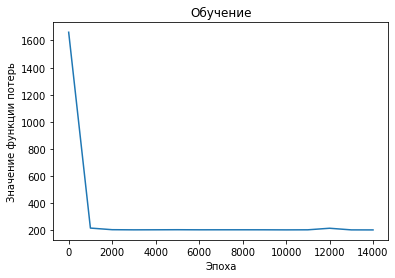

In [73]:
plt.plot(epoch_indexes, loss_values)
plt.title('Обучение')
plt.xlabel('Эпоха')
plt.ylabel('Значение функции потерь')
plt.show()

In [75]:
with torch.no_grad():
  y_pred = net(x_test)
  loss_value=loss_fn(y_pred, y_test)
  

y_pred_3 = y_pred.cpu().numpy()
y_test_3 = y_test.cpu().numpy()

print(f'MAE на предсказанных данных - {loss_value.data}')

MAE на предсказанных данных - 203.95480346679688


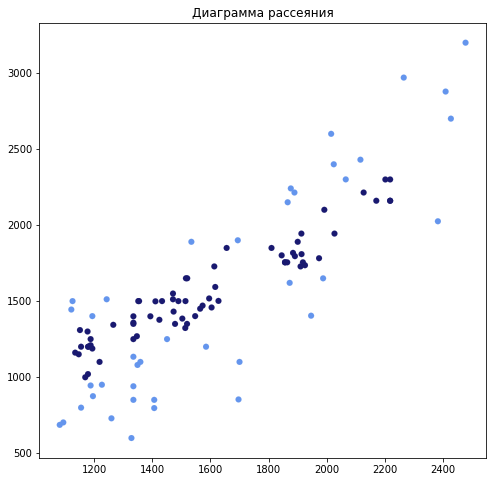

In [77]:
col = np.empty_like(y_pred_3)
right_points = (abs(y_pred_3 - y_test_3) < 200)    
points = (abs(y_pred_3 - y_test_3) > 200)

col[right_points] = 1
col[points] = 0
colors = ['midnightblue' if i == 1.0 else 'cornflowerblue' for i in col]


plt.figure(figsize=(8,8))
scatter = plt.scatter(y_pred_3, y_test_3, c=colors, linewidth=0.1)
plt.title('Диаграмма рассеяния')
plt.show()